In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sa 

from tqdm.auto import tqdm

plt.style.use('ggplot')

Зададим функцию бустрапирования. Почему будем использовать бутстрап - ниже. Поскольку данные уже исследованы и функции лучше обьявить в начале, то вот она:

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
active_users = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/active_users.csv')
groups = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/groups.csv')
purchases = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/purchases.csv')

In [4]:
#посмотрим на данные
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [5]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [6]:
purchases.sort_values('revenue')

,user_id,revenue
521,9146,207.0
369,876,207.0
397,8201,208.0
330,1482,208.0
497,1796,208.0
...,...,...
224,591,3670.0
511,1227,3670.0
253,1606,3671.0
130,6483,3671.0


In [7]:
active_groups = active_users.merge(groups, how='inner', on='user_id')#аналитика по активным юзерам, поэтому объединяем через inner
active_groups_purch = active_groups.merge(purchases, how='left', on='user_id')#есть активные пользователи не совершавшие покупки, объединяем методом left

In [8]:
active_groups_purch.head()

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN


In [9]:
active_groups_purch['rev_result'] = np.where(active_groups_purch.revenue>0, 'pay', 'not pay')

In [10]:
active_groups_purch = active_groups_purch.fillna(0) 

In [11]:
active_groups_purch.head()

,user_id,country,platform,sex,group,revenue,rev_result
0,8029,Russia,ios,male,B,0.0,not pay
1,1735,Sweden,ios,male,B,0.0,not pay
2,7697,Russia,android,male,B,0.0,not pay
3,1421,Sweden,android,female,B,0.0,not pay
4,1704,Russia,ios,male,B,0.0,not pay


In [12]:
active_groups_purch.dtypes

user_id         int64
country        object
platform       object
sex            object
group          object
revenue       float64
rev_result     object
dtype: object

In [13]:
active_groups_purch.loc[active_groups_purch.duplicated()] #проверяем на личие дублей

,user_id,country,platform,sex,group,revenue,rev_result


In [14]:
active_groups_purch.describe()

,user_id,revenue
count,8341.000000,8341.000000
mean,4170.000000,56.553291
std,2407.983631,311.346849
min,0.000000,0.000000
25%,2085.000000,0.000000
50%,4170.000000,0.000000
75%,6255.000000,0.000000
max,8340.000000,4660.000000


Изучим группы внимательне: посмотрим численность, а также на метрики: средний доход с пользователя, средний доход с платящего пользователя, конверсию. Данные метрики релевантны -- позволяют оценить наш доход и сравнить группы, чувствительны, понятны.

In [15]:
active_groups_purch.groupby('group').agg({'revenue': 'count'})

,revenue
group,
A,1538
B,6803


In [36]:
active_groups_purch

,user_id,country,platform,sex,group,revenue,rev_result
0,8029,Russia,ios,male,B,0.0,not pay
1,1735,Sweden,ios,male,B,0.0,not pay
2,7697,Russia,android,male,B,0.0,not pay
3,1421,Sweden,android,female,B,0.0,not pay
4,1704,Russia,ios,male,B,0.0,not pay
...,...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,0.0,not pay
8337,3755,Russia,ios,male,A,590.0,pay
8338,4594,Sweden,android,female,B,0.0,not pay
8339,7430,Sweden,ios,female,B,0.0,not pay


In [16]:
active_groups_purch.groupby('group').agg({'revenue': 'mean'}) #средний доход с пользователя(ARPU)

,revenue
group,
A,47.853056
B,58.520212


In [17]:
active_groups_purch.query('revenue>0').groupby('group').agg({'revenue': 'mean'}) #средний доход с платящего пользователя

,revenue
group,
A,943.564103
B,1267.875796


In [18]:
 pd.crosstab(active_groups_purch.group, active_groups_purch.rev_result).apply(lambda x: x/x.sum(), axis=1).round(3) #конверсия

rev_result,not pay,pay
group,,
A,0.949,0.051
B,0.954,0.046


In [19]:
tab = pd.crosstab(active_groups_purch.group, active_groups_purch.rev_result)

Посмотрим на распределение revenue отдельно внутри контрольной(А) и тестовой (В) группах:

<AxesSubplot:xlabel='revenue', ylabel='Count'>

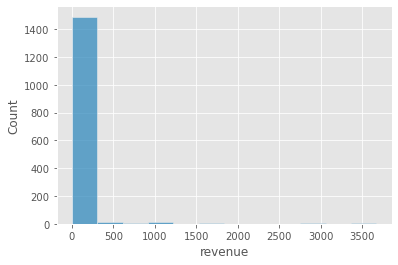

In [34]:
sns.histplot(active_groups_purch[active_groups_purch.group == 'A'].revenue, kde=False)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

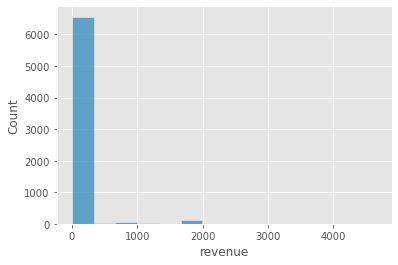

In [35]:
sns.histplot(active_groups_purch[active_groups_purch.group == 'B'].revenue, kde=False)

Подсчет метрик показал, что, на первый взгляд, тестовая группа лучше. Проверим не случайность ли это. Группы не равны, распределение показателя revenue ожидаемо далеко от нормального как для 
контрольной, так и для тестовой групп. Для сравнения средних воспользуемся бутстрапом. Сформулируем гипотезы: Ho  -  разницы между средними в группах А и В нет нет. Н1 - разинца между средними есть.

Сравним средние по показателю дохода на пользователя (ARPU):

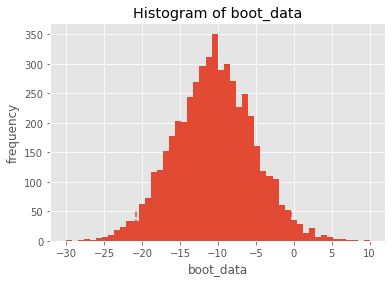

0.0438564252908325

In [22]:
df_all = get_bootstrap(
    active_groups_purch[active_groups_purch.group == 'A' ].revenue, # числовые значения первой выборки
    active_groups_purch[active_groups_purch.group == 'B'].revenue, # числовые значения второй выборки
    boot_it = 5000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_all["p_value"]

In [23]:
total_pay_A = active_groups_purch.query('group == "A" and revenue>0').group.count()
total_pay_B = active_groups_purch.query('group == "B" and revenue>0').group.count()

Сравним средние по показателю дохода на платящего пользователя (ARPPU):

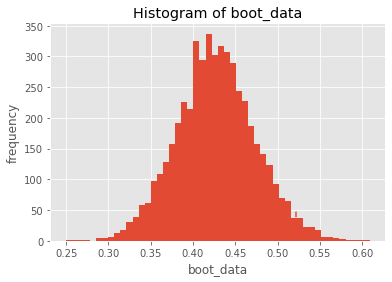

4.967347805283273e-20

In [24]:
df_all = get_bootstrap(
    active_groups_purch[active_groups_purch.group == 'A' ].revenue/total_pay_A, # числовые значения первой выборки
    active_groups_purch[active_groups_purch.group == 'B'].revenue/total_pay_B, # числовые значения второй выборки
    boot_it = 5000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_all["p_value"]

p-value<0,05 dв обоих тестах, 0 лежит на графиках за пределами доверительного интервала - отклоняем нулевые гипотезы на уровне значимости 95%. 

Посмотрим на структуру данных (пол, страна, платформа) в группах. Сохраняется ли в группах соотношение характеристик пользователей?

In [25]:
pd.crosstab(active_groups_purch.group, active_groups_purch.platform).apply(lambda x: x/x.sum(), axis=1)

platform,android,ios
group,,
A,0.542263,0.457737
B,0.556666,0.443334


In [26]:
 pd.crosstab(active_groups_purch.group, active_groups_purch.country).apply(lambda x: x/x.sum(), axis=1)

country,Russia,Sweden
group,,
A,0.594928,0.405072
B,0.660297,0.339703


В контрольной и тестовой группах диспропорция между пользователя из разных стран. Оценим влияние новой модели оплаты отдельно по странам.

In [27]:
df_sweden_a = active_groups_purch.query('group == "A" and country== "Sweden"')
df_sweden_b = active_groups_purch.query('group == "B" and country== "Sweden"')

In [28]:
total_pay_sw_a = df_sweden_a.query('revenue>0').user_id.count()
total_pay_sw_b =df_sweden_b.query('revenue>0').user_id.count()

Для сравнения средних снова воспользуемся бутстрапом. Сформулируем гипотезы: Ho - разницы между средними в группах А и В нет нет. Н1 - разинца между средними есть. ARPU для Швеции:

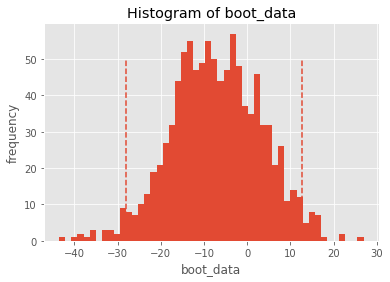

0.4961487001366872

In [29]:
df_sweden_stat_ARPU= get_bootstrap(
    df_sweden_a.revenue, # числовые значения первой выборки
    df_sweden_b.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_sweden_stat_ARPU["p_value"]

p-value >0,05, отклонить нудевыю гипотезу не можем, принимаем ее.

Сравним ARPPU в группах для Швеции:

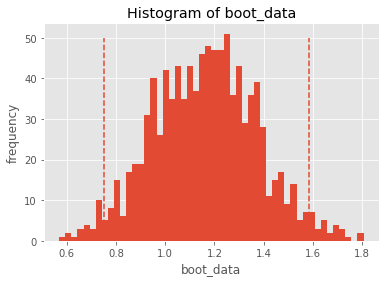

2.7620792042355783e-08

In [30]:
df_sweden_stat_ARPPU= get_bootstrap(
    df_sweden_a.revenue/total_pay_sw_a, # числовые значения первой выборки
    df_sweden_b.revenue/total_pay_sw_b, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_sweden_stat_ARPPU["p_value"]

p-value<0,05 -- отклоняем нулевую гипотезу.

Оценим изменение метрик для российского сегмента. Нулевые гипотезы те же: средние в контрольных и тестовых выборки не отличаются.

In [31]:
df_ru_a = active_groups_purch.query('group == "A" and country== "Russia"')
df_ru_b = active_groups_purch.query('group == "B" and country== "Russia"')
total_pay_ru_a = df_ru_a.query('revenue>0').user_id.count()
total_pay_ru_b = df_ru_a.query('revenue>0').user_id.count()

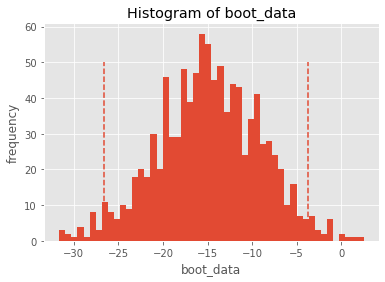

0.009568506762582054

In [32]:
df_russia_stat_ARPU= get_bootstrap(
    df_ru_a.revenue, # числовые значения первой выборки
    df_ru_b.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_russia_stat_ARPU["p_value"]

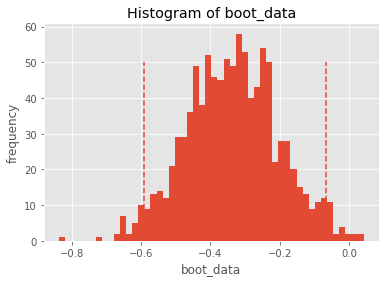

0.01126476743389928

In [33]:
df_russia_stat_ARPPU= get_bootstrap(
    df_ru_a.revenue/total_pay_ru_a, # числовые значения первой выборки
    df_ru_b.revenue/total_pay_ru_b, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
df_russia_stat_ARPPU["p_value"]

p-value < 0,05, 0 не входит в доверительный интервал в обоих случаях -- отклоняем нулевые гипотезы о равенстве средних, получены значимые различия между тестовой и контрольной группами.

Вывод на этом этапе: Получили значимые различия в распределение среднего дохода на пользователя. В выборках тестовой и контрольных групп существовала диспропорция по странам. При анализе показателей ARPU и ARPPU  в разрезе стран были получены значимые различия между контрольной выборкой и тестовой для России. Изменения модели оплаты повысили метрики. Для Швеции не произошло изменений в среднем доходе на пользователя значительно отличающихся от контрольной группы. Однако, есть изменения в доходе на платящего пользователя. Изменнеия модели платежей катим.